In [19]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D,Conv1DTranspose
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM, Bidirectional,ConvLSTM1D,GRU,SimpleRNN
from keras.layers import TimeDistributed,GaussianNoise,Normalization
from keras.layers import RepeatVector,Reshape
from keras.layers import Input
# from attention import Attention 

from keras.layers import BatchNormalization,LayerNormalization,UpSampling1D,Dropout
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.image import load_img
import numpy as np
from numpy import genfromtxt
import cv2
from sklearn.model_selection import train_test_split
from scipy.integrate import odeint
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.interpolate import CubicSpline


# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [20]:
#shuffler
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
    
X_Dat=[]



data_size=173
num_par=9



Y=np.zeros((data_size,num_par))
X=np.zeros((data_size,num_par))

for i in range(data_size): 
  outputer = genfromtxt("D:\Research_work\My_covid_research2\dataset_preprocessing\parameter_estim\output\parameters_ "+str(i)+" .csv", delimiter=',')
  inputer = genfromtxt("D:\Research_work\My_covid_research2\dataset_preprocessing\sub_dataset_gen\output_sg_interpolated\parameters_ "+str(i)+" .csv", delimiter=',')
  inter=inputer[0:inputer.size:3]
  outer=outputer
  X[i,0:num_par]=inter[0:num_par]
  Y[i,0:num_par]=outer[0:num_par]

X = np.expand_dims(X, axis=2)
X,Y=unison_shuffled_copies(X, Y)
X,Y=unison_shuffled_copies(X, Y)
# Split the dataset
split_train = int(len(X)*0.9)
split_valid = int(len(X)*0.98)

# Train
X_train = X[:split_train, :]; y_train=Y[:split_train, :]

# Valid
X_valid = X[split_train:split_valid,:]; y_valid=Y[split_train:split_valid,:]

# Test
X_test = X[split_valid:,:]; y_test=Y[split_valid:,:]
   
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)


(155, 9, 1) (155, 9)
(14, 9, 1) (14, 9)
(4, 9, 1) (4, 9)


In [21]:
input_shape=[num_par,1]
activators=['linear','elu','selu','softplus','swish','softsign','relu','tanh','linear']



conv1d_first_layer_filters=86
conv1d_second_layer_filters=43
conv1d_third_layer_filters=21

conv1d_first_layer_kernel=7
conv1d_second_layer_kernel=3
conv1d_third_layer_kernel=1

strider=2

act_conv1d_first_layer='tanh'
act_conv1d_second_layer='swish'
act_conv1d_third_layer='swish'

seond_last_dense_num=710
act_second_last_dense='tanh'

def main_approximator(inputs):
        x= Conv1D(filters=conv1d_first_layer_filters, kernel_size=conv1d_first_layer_kernel,
                # strides=strider, padding="causal",
                activation=act_conv1d_first_layer)(inputs)
        # x=MaxPooling1D()(x)
        # x=Dropout(0.1)(x)
        x= BatchNormalization()(x)
        x= Conv1D(filters=conv1d_second_layer_filters, kernel_size=conv1d_second_layer_kernel,
                # strides=strider,
                activation=act_conv1d_second_layer)(x)
        # x=MaxPooling1D()(x)
        # x=Dropout(0.1)(x)
        x=BatchNormalization()(x)
        x= Conv1D(filters=conv1d_third_layer_filters, kernel_size=conv1d_third_layer_kernel,
                # strides=strider,
                activation=act_conv1d_third_layer)(x)
        # x=Dropout(0.1)(x)
        # x=MaxPooling1D()(x)
        # x=LayerNormalization()(x)
        # x= GRU(100, return_sequences=True)(x)
        # x= GRU(20, return_sequences=True)(x)
        x= Flatten()(x)
        x= Dense(seond_last_dense_num, activation=act_second_last_dense) (x)
        x = Dropout(0.4)(x)
        # # x=BatchNormalization()(x)
        # x= Dense(600*2, activation='linear') (x)
        x= Dense(num_par, activation='linear')(x)
        return x

def build_model(
        input_shape
):
        inputs = keras.Input(shape=input_shape)
        x = inputs

        # x=LayerNormalization()(x)
        x=1/0.05*tf.math.atanh(x)
        x= main_approximator(x)
        outputs=x
        return keras.Model(inputs, outputs)

model = build_model(
        input_shape,
)

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=64,verbose=0, epochs=200, validation_data=(X_valid, y_valid))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']
# model.save('deformer_models/deformer'+str(indexer)+'.h5')




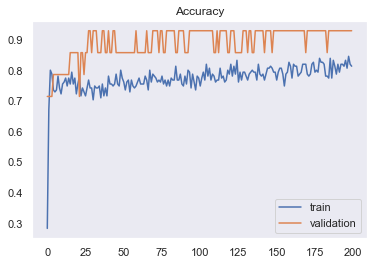

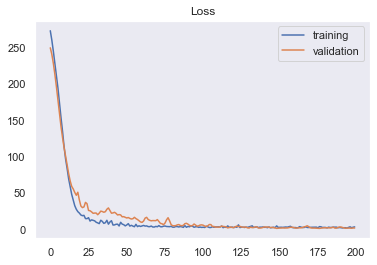

In [22]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Apply the default theme
sns.set_theme()

plt.figure()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc,label='train')
plt.plot(epochs, val_acc,label='validation')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.figure()

plt.plot(epochs, loss,label='training')
plt.plot(epochs, val_loss,label='validation')
plt.title('Loss')
plt.grid()
plt.legend()

In [23]:
model.save('deformer4.h5')